In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import xgboost as xgb
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import os
from typing import Dict, List, Tuple
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import Sequential, layers
from pathlib import Path

In [3]:
df = pd.read_csv("/Users/sohinikar/M.Tech_Dissertation/Obfuscated-MalMem2022.csv")
df.head()

,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class
0,Benign,45,17,10.555556,0,202.844444,1694,38.500000,9129,212.302326,...,221,26,24,116,0,121,87,0,8,Benign
1,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,222,26,24,118,0,122,87,0,8,Benign
2,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,222,26,27,118,0,120,88,0,8,Benign
3,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,222,26,27,118,0,120,88,0,8,Benign
4,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,222,26,24,118,0,124,87,0,8,Benign


# Data Cleaning

In [4]:
# checking all the values in the columns are indetical
for column in df.columns:
    if df[column].nunique() == 1:
        print(f"All values in {column} are identical.")

All values in pslist.nprocs64bit are identical.
All values in handles.nport are identical.
All values in svcscan.interactive_process_services are identical.


In [5]:
columns_to_drop = ['pslist.nprocs64bit', 'handles.nport', 'svcscan.interactive_process_services']

# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

In [6]:
#checking for columns with null values

null_columns = df.columns[df.isnull().any()]
print("Columns with nulls:", list(null_columns))

Columns with nulls: []


# Encoding

In [7]:
def clean_category(value):
    if pd.isnull(value):
        return value
    # Split at the first "-" and take only the first part
    family = value.split("-")[0]
    # Convert to lowercase and remove extra spaces
    family = re.sub(r'\s+', ' ', family.strip().lower())
    return family

df["Category"] = df["Category"].apply(clean_category)


In [14]:
X = df.drop(columns=["Category","Class"])   # all columns except Category are features
y = df["Category"]                  # Category is the target

In [15]:
X.shape

(58596, 52)

In [16]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

In [21]:
X_test.shape

(17579, 52)

In [22]:
# Ensure numpy arrays
X_test = np.asarray(X_test)
y_test = np.asarray(y_test).reshape(-1)

# Randomly pick 5888 indices
rng = np.random.default_rng(42)  # seed for reproducibility
sample_idx = rng.choice(len(X_test), size=5888, replace=False)

# Extract sampled sets
X_sampled = X_test[sample_idx]
y_sampled = y_test[sample_idx]

# Remove those rows to form reduced test set
mask = np.ones(len(X_test), dtype=bool)
mask[sample_idx] = False

X_test = X_test[mask]
y_test = y_test[mask]

print("X_sampled:", X_sampled.shape)   # (5888, 52)
print("y_sampled:", y_sampled.shape)   # (5888,)
print("Remaining X_test:", X_test.shape)  # (17579-5888, 52) = (11691, 52)
print("Remaining y_test:", y_test.shape)  # (11691,)

X_sampled: (5888, 52)
y_sampled: (5888,)
Remaining X_test: (11691, 52)
Remaining y_test: (11691,)


In [24]:
# ---- config ----
BASE_DIR_FNN  = Path("/Users/sohinikar/FL/M.Tech_Dissertation/Client/data/FNN_MC_test_data")
BASE_DIR_LSTM = Path("/Users/sohinikar/FL/M.Tech_Dissertation/Client/data/LSTM_MC_test_data")
USER_COUNT = 128
TOTAL_SAMPLES = len(X_sampled)   # should be 5888
SAMPLES_PER_USER = TOTAL_SAMPLES // USER_COUNT  # 46

# ---- ensure numpy arrays ----
X_sampled = np.asarray(X_sampled)
y_sampled = np.asarray(y_sampled).reshape(-1)

n, d = X_sampled.shape
assert n == len(y_sampled), "X_sampled and y_sampled must have the same number of rows"

# ---- prepare LSTM reshaped data ----
X_sampled_lstm = X_sampled.reshape((n, 1, d)).astype(np.float32)
y_sampled_lstm = y_sampled.astype(np.float32)

# ---- helper to save per-user ----
def save_user_data(base_dir, X, y, is_lstm=False):
    base_dir.mkdir(parents=True, exist_ok=True)
    cols = [f"f{i:02d}" for i in range(X.shape[-1])] if not is_lstm else [f"t0_f{i:02d}" for i in range(X.shape[-1])]

    for user_id in range(1, USER_COUNT + 1):
        start = (user_id - 1) * SAMPLES_PER_USER
        end = start + SAMPLES_PER_USER

        user_dir = base_dir / f"user_{user_id:03d}"
        user_dir.mkdir(parents=True, exist_ok=True)

        if is_lstm:
            # flatten (samples, 1, features) -> (samples, features)
            X_chunk = X[start:end, 0, :]
        else:
            X_chunk = X[start:end]

        y_chunk = y[start:end]

        # Save features
        pd.DataFrame(X_chunk, columns=cols).to_csv(user_dir / "X.csv", index=False)
        # Save labels
        pd.DataFrame({"label": y_chunk}).to_csv(user_dir / "y.csv", index=False)

# ---- save both FNN + LSTM sets ----
save_user_data(BASE_DIR_FNN,  X_sampled,      y_sampled,      is_lstm=False)
save_user_data(BASE_DIR_LSTM, X_sampled_lstm, y_sampled_lstm, is_lstm=True)

print(f"✅ Done. Created {USER_COUNT} folders each under:")
print(f"   {BASE_DIR_FNN}")
print(f"   {BASE_DIR_LSTM}")

✅ Done. Created 128 folders each under:
   /Users/sohinikar/FL/M.Tech_Dissertation/Client/data/FNN_MC_test_data
   /Users/sohinikar/FL/M.Tech_Dissertation/Client/data/LSTM_MC_test_data


In [25]:
X_test.shape

(11691, 52)

In [26]:
fnn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(52,)),  # 52 input features
    tf.keras.layers.Dense(210, activation='tanh', kernel_initializer='he_normal'),  
    tf.keras.layers.Dense(150, activation='tanh', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.4),  # dropout to avoid overfitting
    tf.keras.layers.Dense(90, activation='tanh', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.4),  # dropout
    tf.keras.layers.Dense(4, activation='softmax')  # output layer for multiclass classification
])

# Compile the model
fnn_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')]
)


# Summary
fnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 210)            │        11,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        31,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 90)             │        13,590 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,734 (221.62 KB)

 Trainable params: 56,734 (221.62 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, mode='min',
                  restore_best_weights=True, verbose=1)
]

In [28]:
start = time.time()
history = fnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)
end = time.time()

print(f"\nTraining time: {end - start:.3f} seconds")

Epoch 1/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.6804 - loss: 0.6742 - val_acc: 0.7347 - val_loss: 0.5035
Epoch 2/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.7254 - loss: 0.5335 - val_acc: 0.7368 - val_loss: 0.4940
Epoch 3/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.7323 - loss: 0.5105 - val_acc: 0.7570 - val_loss: 0.4772
Epoch 4/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.7456 - loss: 0.4969 - val_acc: 0.7587 - val_loss: 0.4815
Epoch 5/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.7499 - loss: 0.4892 - val_acc: 0.7655 - val_loss: 0.4671
Restoring model weights from the end of the best epoch: 5.

Training time: 2.420 seconds


In [29]:
# Evaluate model
test_loss, test_acc = fnn_model.evaluate(X_test, y_test, verbose=0)
print(f"[FNN-MC] Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

# Predict probabilities & labels
y_prob = fnn_model.predict(X_test, verbose=0)   # shape: (N, 4)
y_pred = np.argmax(y_prob, axis=1)          # predicted classes
# shape: (N,)

[FNN-MC] Test loss: 0.4671 | Test accuracy: 0.7655


In [30]:
from sklearn.metrics import classification_report

class_names = ["benign", "ransomware", "spyware", "trojan horse"]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))


Classification Report:
              precision    recall  f1-score   support

      benign     0.9998    0.9998    0.9998      5819
  ransomware     0.5774    0.3370    0.4256      1926
     spyware     0.6005    0.4961    0.5433      2048
trojan horse     0.4797    0.7724    0.5918      1898

    accuracy                         0.7655     11691
   macro avg     0.6644    0.6513    0.6401     11691
weighted avg     0.7758    0.7655    0.7590     11691



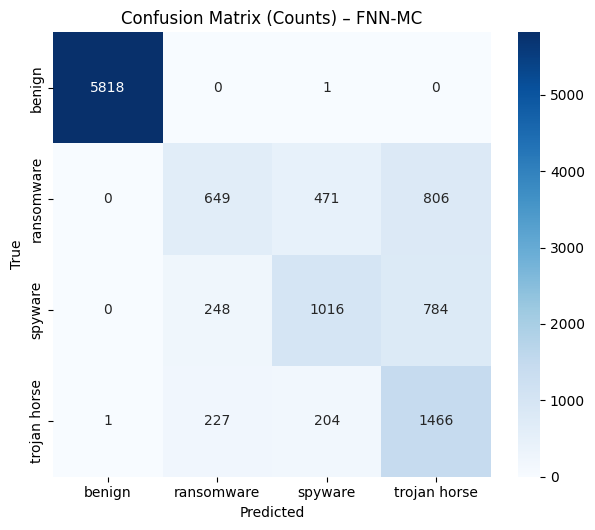

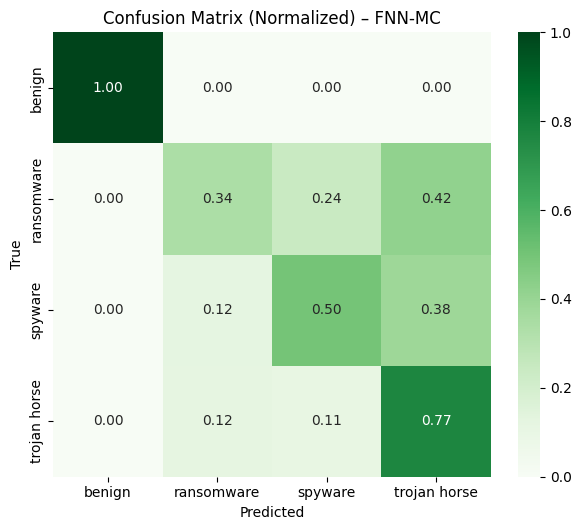

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3])
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6.2, 5.4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Counts) – FNN-MC")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6.2, 5.4))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=1)
plt.title("Confusion Matrix (Normalized) – FNN-MC")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [32]:
X_train_lstm = np.expand_dims(X_train.astype(np.float32), axis=1)  # (N, 1, 52)
X_test_lstm  = np.expand_dims(X_test.astype(np.float32),  axis=1)  # (N, 1, 52)

In [34]:
num_classes = 4
lstm_model = Sequential([
    # timesteps=1, features=52
    tf.keras.Input(shape=(1, 52)),

    # LSTM layer 1 (use tanh for activation; recurrent_activation stays sigmoid by default)
    layers.LSTM(200, activation='tanh', return_sequences=True),
    layers.Dropout(0.5),

    # LSTM layer 2
    layers.LSTM(150, activation='tanh'),
    layers.Dropout(0.5),

    # Output for 4 classes
    layers.Dense(num_classes, activation='softmax')
], name="LSTM_MC")

lstm_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',            # sparse labels (0..3)
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')]
)

lstm_model.summary()

Model: "LSTM_MC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 200)         │       202,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 150)            │       210,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           604 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 413,604 (1.58 MB)

 Trainable params: 413,604 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
start = time.time()
history = lstm_model.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=5,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)
end = time.time()
print(f"\n[LSTM-MC] Training time: {end - start:.3f} seconds")

Epoch 1/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.6636 - loss: 0.7166 - val_acc: 0.6933 - val_loss: 0.5316
Epoch 2/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.7082 - loss: 0.5304 - val_acc: 0.7276 - val_loss: 0.5071
Epoch 3/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.7279 - loss: 0.5053 - val_acc: 0.7405 - val_loss: 0.4938
Epoch 4/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.7395 - loss: 0.4970 - val_acc: 0.7466 - val_loss: 0.4873
Epoch 5/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.7503 - loss: 0.4848 - val_acc: 0.7531 - val_loss: 0.4801
Restoring model weights from the end of the best epoch: 5.

[LSTM-MC] Training time: 8.409 seconds


In [36]:
y_pred_lstm = lstm_model.predict(X_test_lstm)   # your trained LSTM model
y_pred_lstm = y_pred_lstm.argmax(axis=1)

# Convert y_test if one-hot encoded
if y_test.ndim > 1:
    y_test_labels = y_test.argmax(axis=1)
else:
    y_test_labels = y_test

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step


In [37]:
from sklearn.metrics import classification_report

class_names = ["benign", "ransomware", "spyware", "trojan horse"]

print("\nClassification Report (LSTM-MC):")
print(classification_report(y_test, y_pred_lstm, target_names=class_names, digits=4))



Classification Report (LSTM-MC):
              precision    recall  f1-score   support

      benign     0.9993    0.9990    0.9991      5819
  ransomware     0.4506    0.5452    0.4934      1926
     spyware     0.5389    0.5518    0.5452      2048
trojan horse     0.5612    0.4278    0.4855      1898

    accuracy                         0.7531     11691
   macro avg     0.6375    0.6309    0.6308     11691
weighted avg     0.7571    0.7531    0.7529     11691



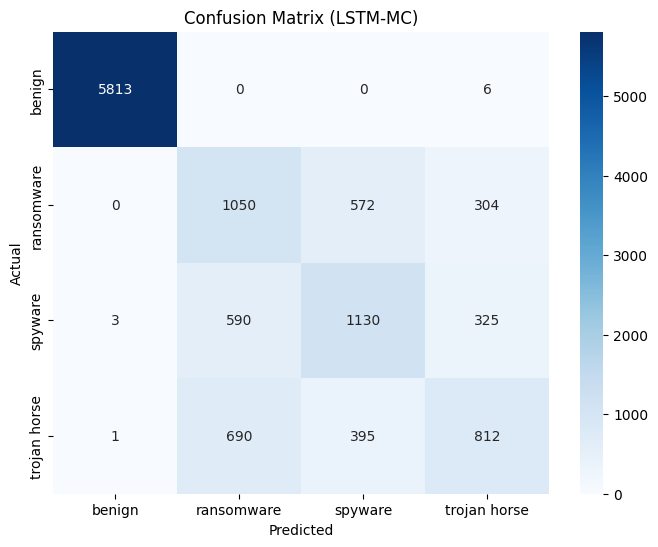

In [38]:
cm = confusion_matrix(y_test, y_pred_lstm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (LSTM-MC)")
plt.show()


In [39]:
# Save full model (preferred modern way)
fnn_model.save("/Users/sohinikar/FL/M.Tech_Dissertation/Server/global_model/global_FNN_MC_model.keras")
lstm_model.save("/Users/sohinikar/FL/M.Tech_Dissertation/Server/global_model/global_lstm_MC_model.keras")